## Introduction

Aim of this notebook is to simulate the Heston model via Monte Carlo using Python and calibrate the model using actual market data using a numerical and deep learning approach. To start with vanilla options data will be used before moving on to more complex options that will require finite-difference methods.

The Heston model is a popular stochastic volatility model for the following reasons:
 - Closed-form solution for European option pricing
 - No risk of negative variances
 - Incorporation of leverage effect 

 References:

### Heston Model SDE
The heston model is defined by a system of SDEs, to describe the movement of asset prices, where an
asset’s price and volatility follow random, Brownian motion processes (this is under real world measure $\mathbb{P}$):

$$ \large dS_t = \mu S_t dt + \sqrt{v_t}S_t dW^\mathbb{P}_{S,t}$$
    
$$\large dv_t = \kappa(\theta - v_t)dt +\sigma \sqrt{v_t} dW^\mathbb{P}_{v,t}$$

Where the variables are:
- $v_t$  instantaneous variance a CIR process
- $\sigma$ volatility of volatility
- $\theta$ long-term price variance
- $\kappa$ rate of reversion to the long-term price variance
- $dW^\mathbb{P}_{S,t}$ Brownian motion of asset price
- $dW^\mathbb{P}_{v,t}$ Brownian motion of asset's price variance
- $\rho^\mathbb{P}$ correlation between $dW^\mathbb{P}_{S,t}$ and $dW^\mathbb{P}_{v,t}$

Dynamics under risk-neutral measure $\mathbb{Q}$:

$$\large dS_t = r S_t dt + \sqrt{v_t}S_t dW^\mathbb{Q}_{S,t}$$
    
$$\large dv_t = \kappa^\mathbb{Q}(\theta^\mathbb{Q} - v_t)dt +\sigma^\mathbb{Q} \sqrt{v_t} dW^\mathbb{Q}_{v,t}$$

## Heston Model for Monte Carlo Simulations

Discretisation of the SDE is not required for valuing a European option.

### Euler Discretisation of SDEs

If we want to value other option types with complex features, using the Heston model then we the SDEs need to be discretised:

Useful reference: Euler and Milstein Discretization by Fabrice Douglas Rouah https://frouah.com/finance%20notes/Euler%20and%20Milstein%20Discretization.pdf

$$\Large dS_{i+1} = S_i e^{(r-\frac{v_i}{2}) \Delta t + \sqrt{v_{i}}\Delta tW^\mathbb{Q}_{S,i+1}}$$
    
$$\large v_{i+1} = v_i + \kappa(\theta - v_t)\Delta t +\sigma \sqrt{v_i} \Delta t W^\mathbb{Q}_{v,i+1}$$

In [1]:
#import libaries 

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from py_vollib_vectorized_2 import vectorized_implied_volatility as implied_vol

In [2]:
# Parameters
# simulation dependent
S0 = 100.0             # asset price
T = 1.0                # time in years
r = 0.02               # risk-free rate
N = 252                # number of time steps in simulation
M = 1000               # number of simulations

# Heston dependent parameters
kappa = 3              # rate of mean reversion of variance under risk-neutral dynamics
theta = 0.20**2        # long-term mean of variance under risk-neutral dynamics
v0 = 0.25**2           # initial variance under risk-neutral dynamics
rho = 0.7              # correlation between returns and variances under risk-neutral dynamics
sigma = 0.6            # volatility of volatility

theta, v0

(0.04000000000000001, 0.0625)

In [3]:
def heston_model_sim(S0, v0, rho, kappa, theta, sigma,T, N, M):
    """
    Inputs:
     - S0, v0: initial parameters for asset and variance
     - rho   : correlation between asset returns and variance
     - kappa : rate of mean reversion in variance process
     - theta : long-term mean of variance process
     - sigma : vol of vol / volatility of variance process
     - T     : time of simulation
     - N     : number of time steps
     - M     : number of scenarios / simulations

    Outputs:
    - asset prices over time (numpy array)
    - variance over time (numpy array)
    """
    # initialise other parameters
    dt = T/N
    mu = np.array([0,0])
    cov = np.array([[1,rho],
                    [rho,1]])

    # arrays for storing prices and variances
    S = np.full(shape=(N+1,M), fill_value=S0)
    v = np.full(shape=(N+1,M), fill_value=v0)

    # sampling correlated brownian motions under risk-neutral measure
    Z = np.random.multivariate_normal(mu, cov, (N,M))

    for i in range(1,N+1):
        S[i] = S[i-1] * np.exp( (r - 0.5*v[i-1])*dt + np.sqrt(v[i-1] * dt) * Z[i-1,:,0] )
        v[i] = np.maximum(v[i-1] + kappa*(theta-v[i-1])*dt + sigma*np.sqrt(v[i-1]*dt)*Z[i-1,:,1],0)
    return S, v

In [4]:
rho_p = 0.98
rho_n = -0.98

S_p,v_p = heston_model_sim(S0, v0, rho_p, kappa, theta, sigma,T, N, M)
S_n,v_n = heston_model_sim(S0, v0, rho_n, kappa, theta, sigma,T, N, M)

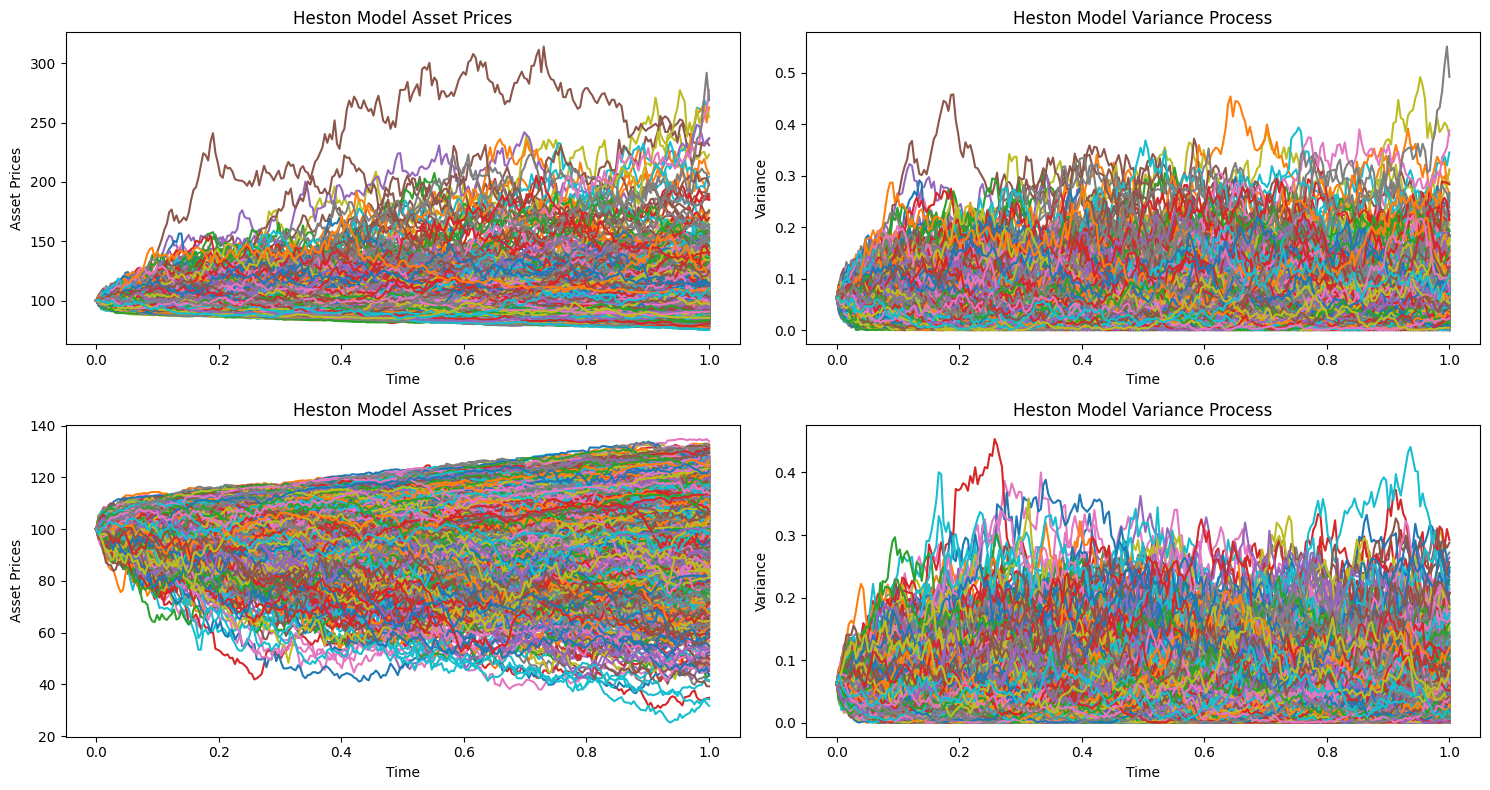

In [5]:
fig, ax  = plt.subplots(2, 2, figsize=(15,8))
time = np.linspace(0,T,N+1)

ax1 ,ax2,ax3,ax4 = ax.flatten()

ax1.plot(time,S_p)
ax1.set_title('Heston Model Asset Prices')
ax1.set_xlabel('Time')
ax1.set_ylabel('Asset Prices')

ax2.plot(time,v_p)
ax2.set_title('Heston Model Variance Process')
ax2.set_xlabel('Time')
ax2.set_ylabel('Variance')


ax3.plot(time,S_n)
ax3.set_title('Heston Model Asset Prices')
ax3.set_xlabel('Time')
ax3.set_ylabel('Asset Prices')

ax4.plot(time,v_n)
ax4.set_title('Heston Model Variance Process')
ax4.set_xlabel('Time')
ax4.set_ylabel('Variance')

plt.tight_layout()
plt.show()

The stochastic differential equation (SDE) for Geometric Brownian Motion (GBM) is given by:

$$ dS_t = \mu S_t \, dt + \sigma S_t \, dW_t $$

where:
- $S_t$ = asset price at time $t$,
- $\mu$ = drift (expected return),
- $\sigma$ = volatility,
- $W_t$ = standard Wiener process (Brownian motion).

### Step 1: Rearranging the SDE

We start by dividing both sides by $S_t$ to simplify the equation:  $\frac{dS_t}{S_t} = \mu \, dt + \sigma \, dW_t$

### Step 2: Integrating both sides

Integrate both sides from 0 to $t$: $\int_0^t \frac{dS_u}{S_u} = \int_0^t \mu \, du + \int_0^t \sigma \, dW_u$


### Step 3: Solving the integrals

The left-hand side integrates to the logarithm of $S_t$, the first term on the right-hand side integrates to $\mu t$, and the second term is a stochastic integral with solution $\sigma W_t$:

$\ln(S_t) - \ln(S_0) = \mu t + \sigma W_t$

### Step 4: Exponentiating both sides

Exponentiating both sides to solve for $S_t$: $S_t = S_0 \exp \left( \left( \mu - \frac{\sigma^2}{2} \right) t + \sigma W_t \right)$

Thus, the solution to the Geometric Brownian Motion (GBM) SDE is: $S_t = S_0 \exp \left( \left( \mu - \frac{\sigma^2}{2} \right) t + \sigma W_t \right)$

where:
- $S_t$ = asset price at time $t$,
- $S_0$ = initial asset price,
- $\mu$ = drift,
- $\sigma$ = volatility,
- $W_t$ = Wiener process (Brownian motion).

In [6]:
### Asset price distribution with different correlations
# simulate gbm process at time T
gbm = S0*np.exp((r - theta**2/2)*T + np.sqrt(theta)*np.sqrt(T)*np.random.normal(0,1,M))

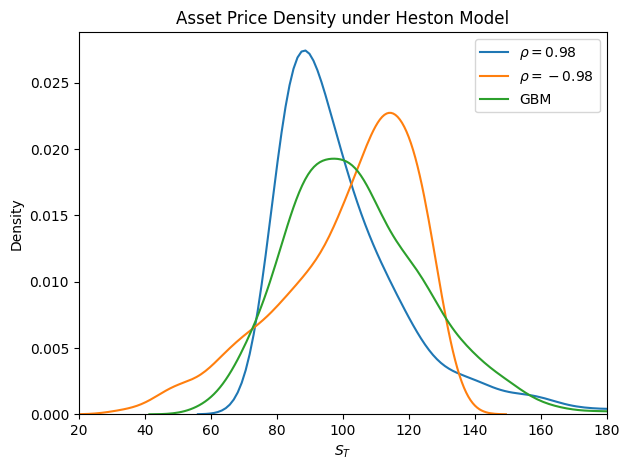

In [7]:
fig, ax = plt.subplots()

ax = sns.kdeplot(S_p[-1], label=r"$\rho= 0.98$", ax=ax)
ax = sns.kdeplot(S_n[-1], label=r"$\rho= -0.98$", ax=ax)
ax = sns.kdeplot(gbm, label="GBM", ax=ax)

plt.title(r'Asset Price Density under Heston Model')
plt.xlim([20, 180])
plt.xlabel('$S_T$')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

### Capturing the Volatililty Smile in Option Pricing

In [8]:
rho = -0.7
S,v = heston_model_sim(S0, v0, rho, kappa, theta, sigma,T, N, M)

In [9]:
# Set strikes and complete MC option price for different strikes
K = np.arange(20,180,2)

puts = np.array([np.exp(-r*T)*np.mean(np.maximum(k-S,0)) for k in K])
calls = np.array([np.exp(-r*T)*np.mean(np.maximum(S-k,0)) for k in K])

put_ivs = implied_vol(puts, S0, K, T, r, flag='p', q=0, return_as='numpy', on_error='ignore')
call_ivs = implied_vol(calls, S0, K, T, r, flag='c', q=0, return_as='numpy')

c:\quant\equity\py_vollib_vectorized_2\implied_volatility.py:75: UserWarning: Found Below Intrinsic contracts at index [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
  below_intrinsic, above_max_price = _check_below_and_above_intrinsic(K, F, flag, undiscounted_option_price, on_error)


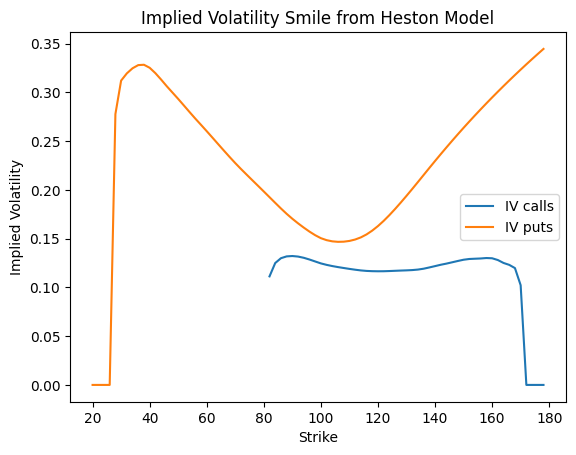

In [10]:
plt.plot(K, call_ivs, label=r'IV calls')
plt.plot(K, put_ivs, label=r'IV puts')

plt.ylabel('Implied Volatility')
plt.xlabel('Strike')

plt.title('Implied Volatility Smile from Heston Model')
plt.legend()
plt.show()

In [11]:
# Set strikes and complete MC option price for different strikes
K = np.arange(20,180,2)

puts = np.array([np.exp(-r*T)*np.mean(np.maximum(k-S,0)) for k in K])
calls = np.array([np.exp(-r*T)*np.mean(np.maximum(S-k,0)) for k in K])

put_ivs = implied_vol(puts, S0, K, T, r, flag='p', q=0, return_as='numpy', on_error='ignore')
call_ivs = implied_vol(calls, S0, K, T, r, flag='c', q=0, return_as='numpy')

### Heston's Stochastic Volatility Model under real world probability measure

$dS_t = \mu S_t dt + \sqrt{v_t} S_t dW^\mathbb{P}_{S,t}$

$dv_t = \kappa (\theta - v_t)dt + \sigma \sqrt{v_t} dW^\mathbb{P}_{v,t}$

$\rho dt = dW^\mathbb{P}_{S,t} dW^\mathbb{P}_{v,t} $

### Using Girsanov's Thereom to $\mathbb{P} \to \mathbb{Q}$
$dW^\mathbb{Q}_{S,t} = dW^\mathbb{P}_{S,t} + \alpha_S dt, \alpha_S  = \frac{\mu_\mathbb{P}-r}{\sqrt{v_t}}$

$dW^\mathbb{Q}_{v,t} = dW^\mathbb{P}_{v,t} + \alpha_v dt, \alpha_v  = \frac{\lambda}{\sigma^\mathbb{P}} \sqrt{v_t}$


### Heston's Stochastic Volatility Model under risk-neutral measure

$dS_t = r S_t dt + \sqrt{v_t} S_t dW^\mathbb{Q}_{S,t}$

$dv_t = \kappa^\mathbb{Q} (\theta^\mathbb{Q} - v_t)dt + \sigma \sqrt{v_t} dW^\mathbb{Q}_{v,t}$

$\rho^\mathbb{Q} dt = dW^\mathbb{Q}_{S,t} dW^\mathbb{Q}_{v,t} $

Where: $\lambda$ is the variance risk premium

$\rho^\mathbb{Q} = \rho, \kappa^\mathbb{Q} = \kappa+\lambda,  \theta^\mathbb{Q} = \kappa \theta/(\kappa+\lambda)$

Notation:
- $S_t$ Equity spot price, financial index
- $v_t$ Variance.
- $C$ European call option price.
- $K$ Strike price.
- $W_{S,v}$ Standard Brownian movements.
- $r$ Interest rate.
- $\kappa$ Mean reversion rate.
- $\theta$ Long run variance.
- $v_0$ Initial variance.
- $\sigma$ Volatility of variance.
- $\rho$ Correlation parameter.
- $t$ Current date.
- $T$ Maturity date.

In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import quad
from scipy.optimize import minimize
from datetime import datetime as dt

#from eod import EodHistoricalData
import yfinance as yf


from nelson_siegel_svensson import NelsonSiegelSvenssonCurve
from nelson_siegel_svensson.calibrate import calibrate_nss_ols

Number of academic papers/online resources for reference:
- Heston Girsanov's Formula: https://quant.stackexchange.com/questions/61927/heston-stochastic-volatility-girsanov-theorem/61931#61931
- Heston PDE               : https://uwspace.uwaterloo.ca/bitstream/handle/10012/7541/Ye_Ziqun.pdf?sequence=1
- Heston Characteristic Eq :https://www.maths.univ-evry.fr/pages_perso/crepey/Finance/051111_mikh%20heston.pdf
- Heston Implementation    : https://hal.sorbonne-universite.fr/hal-02273889/document
- Heston Calibration       : https://calebmigosi.medium.com/build-the-heston-model-from-scratch-in-python-part-ii-5971b9971cbe

Using standard arbitrage arguments we arrive at Garman's partial differential equation:

$\frac{\partial C}{\partial  t} + \frac{S^2 v}{2}\frac{\partial ^2 C}{\partial  S^2} + rS\frac{\partial  C}{\partial  S} - rC + [\kappa(\theta-v)-\lambda v]\frac{\partial  C}{\partial  v} + \frac{\sigma^2 v}{2}\frac{\partial ^2 C}{\partial  v^2} + \rho \sigma Sv \frac{\partial ^2 C}{\partial  S \partial  v} = 0$

Heston builds the solution of the PDE above by the method of characteristic functions. He looks for a solution of the form corresponding to the Black-Scholes model.

$C(S_0, K, v_0, \tau) = SP_1 - Ke^{-r\tau} P_2$

where
- $P_1$ is the delta of the European call option and
- $P_2$ is the conditional risk neutral probability that the asset price will be greater than K at the maturity.


Both probabilities $P_{1,2}$ also satisfy the PDE provided that characteristic functions $\varphi_1$, $\varphi_2$ are known the terms $P_{1,2}$ are defined via the inverse Fourier transformation.

$X = ln(S)$

$P_j = \frac{1}{2} + \frac{1}{\pi}\int^{\inf}_{0} \Re [\frac{e^{-i \phi \ln K} \varphi_j(X_0, K, v_0,\tau; \phi)}{i\phi}] d\phi, j \in \{1,2\}$

Heston assumes the characteristic functions $\varphi_1$, $\varphi_2$ having the form:

$\varphi_j(X_0, K, v_0,\tau; \phi) = e^{C(\tau;\phi)+D(\tau;\phi)v+i\phi X}$

With semianalytical solution:

$C(\tau;\phi) = r\phi i \tau + \frac{a}{\sigma^2}[(b_j -\rho\sigma \phi i + d)\tau - 2ln[\frac{1-ge^{d\tau}}{1-g}])]$

$D(\tau;\phi) = \frac{b_j -\rho\sigma \phi i + d}{\sigma^2}[\frac{1-e^{d\tau}}{1-ge^{d\tau}}]$

where

- $ g = \frac{b_j -\rho\sigma \phi i + d}{b_j -\rho\sigma \phi i - d}$
- $ d = \sqrt{(\rho\sigma \phi i -b_j)^2 - \sigma^2 (2u_j\phi i - \phi^2)}$
- $ u_1 = 0.5, u_2 = -0.5$
- $ a = \kappa \theta$
- $ b_1 = \kappa + \lambda - \rho \sigma$
- $ b_2 = \kappa + \lambda$

In [13]:
def heston_charfunc(phi, S0, v0, kappa, theta, sigma, rho, lambd, tau, r):

    # constants
    a = kappa*theta
    b = kappa+lambd

    # common terms w.r.t phi
    rspi = rho*sigma*phi*1j

    # define d parameter given phi and b
    d = np.sqrt( (rho*sigma*phi*1j - b)**2 + (phi*1j+phi**2)*sigma**2 )

    # define g parameter given phi, b and d
    g = (b-rspi+d)/(b-rspi-d)

    # calculate characteristic function by components
    exp1 = np.exp(r*phi*1j*tau)
    term2 = S0**(phi*1j) * ( (1-g*np.exp(d*tau))/(1-g) )**(-2*a/sigma**2)
    exp2 = np.exp(a*tau*(b-rspi+d)/sigma**2 + v0*(b-rspi+d)*( (1-np.exp(d*tau))/(1-g*np.exp(d*tau)) )/sigma**2)

    return exp1*term2*exp2

### Define the integrand as a function

$\large \int^{\inf}_{0} \Re [ e^{r\tau} \frac{\varphi(\phi-i)}{i\phi K^{i\phi}} - K\frac{\varphi(\phi)}{i\phi K^{i\phi}} ] d\phi$

In [14]:
def integrand(phi, S0, v0, kappa, theta, sigma, rho, lambd, tau, r):
    args = (S0, v0, kappa, theta, sigma, rho, lambd, tau, r)
    numerator = np.exp(r*tau)*heston_charfunc(phi-1j,*args) - K*heston_charfunc(phi,*args)
    denominator = 1j*phi*K**(1j*phi)
    return numerator/denominator

### Numerical integration over integrand and calculate option price

$\large C(S_0, K, v_0, \tau) = \frac{1}{2}(S_0 - Ke^{-r \tau}) + \frac{1}{\pi} \int^{\inf}_{0} \Re [ e^{r\tau} \frac{\varphi(\phi-i)}{i\phi K^{i\phi}} - K\frac{\varphi(\phi)}{i\phi K^{i\phi}} ] d\phi$

### Using rectangular integration

In [15]:
def heston_price_rec(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r):
    args = (S0, v0, kappa, theta, sigma, rho, lambd, tau, r)

    P, umax, N = 0, 100, 10000
    dphi=umax/N #dphi is width

    for i in range(1,N):
        # rectangular integration
        phi = dphi * (2*i + 1)/2 # midpoint to calculate height
        numerator = np.exp(r*tau)*heston_charfunc(phi-1j,*args) - K * heston_charfunc(phi,*args)
        denominator = 1j*phi*K**(1j*phi)

        P += dphi * numerator/denominator

    return np.real((S0 - K*np.exp(-r*tau))/2 + P/np.pi)

### Using scipy integrate quad function

In [16]:
def heston_price(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r):
    args = (S0, v0, kappa, theta, sigma, rho, lambd, tau, r)

    real_integral, err = np.real( quad(integrand, 0, 100, args=args) )

    return (S0 - K*np.exp(-r*tau))/2 + real_integral/np.pi

In [17]:
# Parameters to test model

S0 = 100. # initial asset price
K = 100. # strike
v0 = 0.1 # initial variance
r = 0.03 # risk free rate
kappa = 1.5768 # rate of mean reversion of variance process
theta = 0.0398 # long-term mean variance
sigma = 0.3 # volatility of volatility
lambd = 0.575 # risk premium of variance
rho = -0.5711 # correlation between variance and stock process
tau = 1. # time to maturity

In [18]:
heston_price( S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r )

c:\ProgramData\miniconda3\envs\autoenc1\Lib\site-packages\scipy\integrate\_quadpack_py.py:606: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


11.540361819355368

In [19]:
# Parameters to test model #2

S0 = 5825 # initial asset price
K = 5855.0 # strike
v0 = 0.01 # initial variance
r = 0.05 # risk free rate
kappa = 1.575 # rate of mean reversion of variance process
theta = 0.004 # long-term mean variance
sigma = 0.57 # volatility of volatility
lambd = 0.08 # risk premium of variance
rho = 5e-10 # correlation between variance and stock process
tau = 0.5 # time to maturity

heston_price( S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r )

221.79496542672493

### Risk-free rate from US Daily Treasury Par Yield Curve Rates

https://home.treasury.gov/policy-issues/financing-the-government/interest-rate-statistics?data=yield%27

Parametric Model: Let’s explore a parametric model for arriving at ZC and implied forward rates.

Parametric model for stripping a yield curve with Nelson Siegel Svensson model explained in detail: https://abhyankar-ameya.medium.com/yield-curve-analytics-with-python-e9254516831c

In [20]:
yield_maturities = np.array([1/12, 2/12, 3/12,4/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30])
yields = np.array([4.92,4.82,4.73,4.66,4.47,4.24,4.02,3.95,3.98,4.07,4.19,4.54,4.49]).astype(float)/100

Nelson Siegel Svensson model using ordinary least squares approach

In [21]:
#NSS model calibrate
curve_fit, status = calibrate_nss_ols(yield_maturities,yields)

#Can use the fitted curve to get rate at any tenor point

curve_fit

NelsonSiegelSvenssonCurve(beta0=0.04563032361939878, beta1=0.0036849763147745952, beta2=-0.036081271617350925, beta3=0.01048653576721284, tau1=2.0, tau2=5.0)

### EODHistoricalData API

#### Get Market Option Prices for S&P500 Index
https://eodhistoricaldata.com/r/?ref=ASXPorto

Will also use Yahoo Finance library yfinance and compare

In [22]:
extdata = yf.Ticker("^SPX")

todayData = extdata.history(period='1d')
S0 = todayData['Open'][0]
S0

C:\Users\MITESH\AppData\Local\Temp\ipykernel_27984\106845646.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S0 = todayData['Open'][0]


5826.75

In [23]:
resp = extdata.option_chain('2024-12-20')

data_calls = resp.calls[resp.calls['inTheMoney'] ==False].reset_index(drop = True)

In [24]:
otm_data = pd.concat([resp.calls[resp.calls['inTheMoney'] ==False].reset_index(drop = True), resp.puts[resp.puts['inTheMoney'] ==False].reset_index(drop = True)], axis =0)

otm_data
#resp.puts[resp.puts['inTheMoney'] ==False]

contractSymbol             lastTradeDate  strike  lastPrice    bid  \
0    SPXW241220C05845000 2024-10-23 15:05:10+00:00  5845.0     146.40  150.1   
1    SPXW241220C05850000 2024-10-24 18:39:45+00:00  5850.0     132.89  146.9   
2    SPXW241220C05855000 2024-10-24 19:39:16+00:00  5855.0     132.65  143.9   
3    SPXW241220C05860000 2024-10-24 19:47:41+00:00  5860.0     130.30  140.5   
4    SPXW241220C05865000 2024-10-23 14:54:21+00:00  5865.0     133.30  137.4   
..                   ...                       ...     ...        ...    ...   
286   SPX241220P05820000 2024-10-24 20:01:47+00:00  5820.0     123.13  113.2   
287   SPX241220P05825000 2024-10-25 12:14:40+00:00  5825.0     118.00  114.9   
288  SPXW241220P05830000 2024-10-24 17:06:18+00:00  5830.0     130.40  117.3   
289  SPXW241220P05835000 2024-10-24 19:41:11+00:00  5835.0     129.20  118.8   
290  SPXW241220P05840000 2024-10-24 19:39:49+00:00  5840.0     131.00  120.7   

       ask     change  percentChange  volume  openInterest  impliedVolatility  \
0    150.5   0.000000       0.000000    18.0           116           0.165519   
1    147.3   0.000000       0.000000    49.0          1248           0.164651   
2    144.4   0.000000       0.000000     2.0           107           0.164080   
3    140.9   0.000000       0.000000    11.0           187           0.162831   
4    137.8   0.000000       0.000000     6.0           141           0.161988   
..     ...        ...            ...     ...           ...                ...   
286  113.9   0.000000       0.000000   130.0          4297           0.135099   
287  115.5 -12.300003      -9.439756     3.0          3952           0.134189   
288  117.7   0.000000       0.000000    18.0           100           0.133901   
289  119.3   0.000000       0.000000    18.0            81           0.132924   
290  121.1   0.000000       0.000000    22.0            81           0.132133   

     inTheMoney contractSize currency  
0         False      REGULAR      USD  
1         False      REGULAR      USD  
2         False      REGULAR      USD  
3         False      REGULAR      USD  
4         False      REGULAR      USD  
..          ...          ...      ...  
286       False      REGULAR      USD  
287       False      REGULAR      USD  
288       False      REGULAR      USD  
289       False      REGULAR      USD  
290       False      REGULAR      USD  

[393 rows x 14 columns]

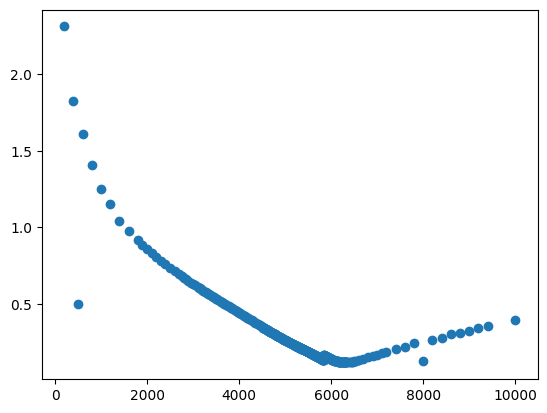

In [25]:
plt.scatter(np.array(otm_data['strike']),np.array(otm_data['impliedVolatility']))
plt.show()

In [26]:
expiry = []
otm_data = []

for i in extdata.options:
    expiry.append(i)
    resp = extdata.option_chain(i)
    #temp_df = pd.concat([resp.calls[resp.calls['inTheMoney'] ==False].reset_index(drop = True), resp.puts[resp.puts['inTheMoney'] ==False].reset_index(drop = True)], axis =0)
    temp_df = resp.calls
    temp_df.insert(0,'Mid','')
    temp_df.insert(0,'Expiry','')
    temp_df.insert(0,'time_to_expiry','')
    temp_df['Expiry'] = i    
    temp_df['time_to_expiry'] = ((dt.strptime(i, '%Y-%m-%d') - dt.today()).days/365.25)
    temp_df['Mid'] = (temp_df['bid']+temp_df['ask'])/2
    otm_data.append(temp_df)

In [27]:
#otm_data
otm_df = pd.concat(otm_data, ignore_index=True)

In [28]:
# resp

# market_prices = {}

# S0 = resp['lastTradePrice']

# for i in resp['data']:
#     market_prices[i['expirationDate']] = {}
#     market_prices[i['expirationDate']]['strike'] = [name['strike'] for name in i['options']['CALL']]# if name['volume'] is not None]
#     market_prices[i['expirationDate']]['price'] = [(name['bid']+name['ask'])/2 for name in i['options']['CALL']]# if name['volume'] is not None]

In [29]:
all_strikes = otm_df['strike'].unique()

print('Number of common strikes:', len(all_strikes))
common_strikes = sorted(all_strikes)

Number of common strikes: 502


In [30]:
volSurface_full = otm_df[['lastPrice', 'time_to_expiry', 'strike', 'Mid']].reset_index(drop = True)

volSurface = volSurface_full[(volSurface_full['time_to_expiry'] > 0.05) & (volSurface_full['time_to_expiry'] < 1) & (volSurface_full['strike'] > 5000) & (volSurface_full['strike'] < 6000)]

In [31]:
# prices = []
# maturities = []

# for date, v in market_prices.items():
#     maturities.append((dt.strptime(date, '%Y-%m-%d') - dt.today()).days/365.25)
#     price = [v['price'][i] for i,x in enumerate(v['strike']) if x in common_strikes]
#     prices.append(price)

# price_arr = np.array(prices, dtype=object)
# np.shape(price_arr)

In [32]:
# volSurface = pd.DataFrame(price_arr, index = expiry, columns = common_strikes)
# volSurface = volSurface.iloc[(volSurface.index > 0.04) & (volSurface.index < 1), (volSurface.columns > 3000) & (volSurface.columns < 5000)]
# volSurface

In [33]:
# Convert our vol surface to dataframe for each option price with parameters
# volSurfaceLong = volSurface.melt(ignore_index=False).reset_index()
# volSurfaceLong.columns = ['maturity', 'strike', 'price']

# Calculate the risk free rate for each maturity using the fitted yield curve
volSurface['rate'] = volSurface['time_to_expiry'].apply(curve_fit)

C:\Users\MITESH\AppData\Local\Temp\ipykernel_27984\814025511.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  volSurface['rate'] = volSurface['time_to_expiry'].apply(curve_fit)


### Parameters to determine via calibration with market prices

https://www.maths.univ-evry.fr/pages_perso/crepey/Finance/051111_mikh%20heston.pdf

$\Large \Theta = (v0, \kappa, \theta, \sigma, \rho, \lambda)$

Minimize squared error:



$SqErr(\Theta) = \sum^N_{i=1}\sum^M_{j=1}w_{ij}(C_{MP}(X_i,\tau_j) - C_{SV}(S_\tau, X_i,\tau_j,r_j,\Theta))^2 + Penalty(\Theta, \Theta_0)$

- The penalty function may be e. g. the distance to the initial parameter $vectorPenalty(\Theta, \Theta_0) = ||\Theta − \Theta_0||^2$


### Calibration - Optimization Objective function

$\hat{\Theta} = \underset{\Theta \in U_\Theta}{arg \ min} \ SqErr(\Theta)$

Here we assume that the  set of possible combinations of parameters $U_\Theta$ is compact and in the range for which a solution exists.

In [34]:
# This is the calibration function
# heston_price(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r)
# Parameters are v0, kappa, theta, sigma, rho, lambd

# Define variables to be used in optimization
S0 = todayData['Open'][0]
r = volSurface['rate'].to_numpy('float')
K = volSurface['strike'].to_numpy('float')
tau = volSurface['time_to_expiry'].to_numpy('float')
P = volSurface['Mid'].to_numpy('float')



params = {"v0": {"x0": 0.1, "lbub": [1e-3,0.1]},
          "kappa": {"x0": 3, "lbub": [1e-3,5]},
          "theta": {"x0": 0.05, "lbub": [1e-3,0.1]},
          "sigma": {"x0": 0.3, "lbub": [1e-2,1]},
          "rho": {"x0": -0.8, "lbub": [-1,0]},
          "lambd": {"x0": 0.03, "lbub": [-1,1]},
          }

# params = {"v0": {"x0": 0.05, "lbub": [1e-3,0.1]},
#           "kappa": {"x0": 3.26, "lbub": [1e-3,5]},
#           "theta": {"x0": 0.05, "lbub": [1e-3,0.1]},
#           "sigma": {"x0": 0.13, "lbub": [1e-2,1]},
#           "rho": {"x0": -0.008, "lbub": [-1,0]},
#           "lambd": {"x0": 0.8, "lbub": [-1,1]},
#           }

x0 = [param["x0"] for key, param in params.items()]
bnds = [param["lbub"] for key, param in params.items()]

def SqErr(x):
    v0, kappa, theta, sigma, rho, lambd = [param for param in x]

    # Attempted to use scipy integrate quad module as constrained to single floats not arrays
    # err = np.sum([ (P_i-heston_price(S0, K_i, v0, kappa, theta, sigma, rho, lambd, tau_i, r_i))**2 /len(P) \
    #               for P_i, K_i, tau_i, r_i in zip(marketPrices, K, tau, r)])

    # Decided to use rectangular integration function in the end
    err = np.sum( (P-heston_price_rec(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r))**2 /len(P) )

    # Zero penalty term - no good guesses for parameters
    pen = 0 #np.sum( [(x_i-x0_i)**2 for x_i, x0_i in zip(x, x0)] )

    return err + pen

C:\Users\MITESH\AppData\Local\Temp\ipykernel_27984\1570124898.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S0 = todayData['Open'][0]


In [35]:
result = minimize(SqErr, x0, tol = 1e-3, method='SLSQP', options={'maxiter': 1e4 }, bounds=bnds)

C:\Users\MITESH\AppData\Local\Temp\ipykernel_27984\2597819352.py:19: RuntimeWarning: overflow encountered in exp
  exp2 = np.exp(a*tau*(b-rspi+d)/sigma**2 + v0*(b-rspi+d)*( (1-np.exp(d*tau))/(1-g*np.exp(d*tau)) )/sigma**2)
C:\Users\MITESH\AppData\Local\Temp\ipykernel_27984\2597819352.py:21: RuntimeWarning: invalid value encountered in multiply
  return exp1*term2*exp2
C:\Users\MITESH\AppData\Local\Temp\ipykernel_27984\3180703940.py:10: RuntimeWarning: invalid value encountered in multiply
  numerator = np.exp(r*tau)*heston_charfunc(phi-1j,*args) - K * heston_charfunc(phi,*args)
c:\ProgramData\miniconda3\envs\autoenc1\Lib\site-packages\scipy\optimize\_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
c:\ProgramData\miniconda3\envs\autoenc1\Lib\site-packages\scipy\optimize\_slsqp_py.py:438: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x),

In [36]:
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 25977.115797027633
       x: [ 2.730e-02  5.000e+00  1.091e-03  1.000e-02 -2.410e-04
            1.000e+00]
     nit: 5
     jac: [-1.520e+04  7.503e+01 -4.806e+04  3.104e+01 -1.640e+00
            8.462e+01]
    nfev: 42
    njev: 5

In [37]:
v0, kappa, theta, sigma, rho, lambd = [param for param in result.x]
v0, kappa, theta, sigma, rho, lambd

(0.027296616420481902,
 5.0,
 0.0010914843573192582,
 0.010000000000000009,
 -0.00024103386486537605,
 1.0)

### Calculate estimated option prices using calibrated parameters

Using heston model with estimated parameters

In [38]:
heston_prices = heston_price_rec(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r)

In [39]:
volSurface['heston_price'] = heston_prices

C:\Users\MITESH\AppData\Local\Temp\ipykernel_27984\1537686975.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  volSurface['heston_price'] = heston_prices


In [40]:
volSurface

lastPrice  time_to_expiry  strike     Mid      rate  heston_price
1791     238.20        0.052019  5600.0  275.20  0.048861    258.121632
1792     220.22        0.052019  5620.0  257.95  0.048861    240.413794
1793     224.02        0.052019  5625.0  253.70  0.048861    236.049042
1794     246.20        0.052019  5630.0  249.40  0.048861    231.710623
1795     198.39        0.052019  5650.0  232.55  0.048861    214.635023
...         ...             ...     ...     ...       ...           ...
5807     438.46        0.974675  5875.0  453.95  0.043050    337.709755
5808     406.82        0.974675  5900.0  437.35  0.043050    316.421022
5809     425.21        0.974675  5925.0  420.45  0.043050    295.556556
5810     426.99        0.974675  5950.0    0.00  0.043050    275.142024
5811     371.69        0.974675  5975.0  388.05  0.043050    255.202077

[2060 rows x 6 columns]

### Plot Market prices vs Heston Prices

In [41]:
import plotly.graph_objects as go
from plotly.graph_objs import Surface
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode()

In [42]:
fig = go.Figure(data=[go.Mesh3d(x=volSurface.time_to_expiry, y=volSurface.strike, z=volSurface.Mid, color='mediumblue', opacity=0.55)])

fig.add_scatter3d(x=volSurface.time_to_expiry, y=volSurface.strike, z=volSurface.heston_price, mode='markers')

fig.update_layout(
    title_text='Market Prices (Mesh) vs Calibrated Heston Prices (Markers)',
    scene = dict(xaxis_title='TIME (Years)',
                    yaxis_title='STRIKES (Pts)',
                    zaxis_title='INDEX OPTION PRICE (Pts)'),
    height=800,
    width=800
)

fig.show()

The plot above shows that our model performed reasonably well. However, we can see numerous datapoints distorting the surface. These points make it difficult for the calibration process to coverge to the optimal paramter set, as it tries to fit the market data the best it can.

Further work needs to be done to clean the market data before feeding it into the calibration process. The next notebook will attempt a Deep learning based calibration.